# Social graphs - Explainer notebook

In [13]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import urllib
import urllib.request
from urllib.request import urlopen
import json
import networkx as nx
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import os
from IPython.display import Image


### **1. Motivation**

* What is your dataset?

Our Datasets consist of 

    - Character list with all characters in Avatar - The last airbender (txt files)
    - Locations list with the location descriptions (txt files)
    - All 61 episode titles (json files) 
    - Transcriptions for every episode (txt files)

* What was your goal for the end user's experience?

Our goal for the end user was to create a website that could give a simple and yet powerfull understanding of the series. We wanted the end user to enter our website without any knowledge about Avatar and leave with enough knowledge to know how to master the 4 element. By how we mean who to speak to and were to go in order. 

* What was your goal for the end user's experience?

Our goal for the end user was to create a website that could give a simple and yet powerfull understanding of the series. We wanted the end user to enter our website without any knowledge about Avatar and leave with enough knowledge to know how to master the 4 element. By how we mean who to speak to and were to go in order. 

### **2. Basic stats. Let's understand the dataset better**

* Write about your choices in data cleaning and preprocessing



The steps for this part is 

1. Get queries for the relevant pages
2. Download all the relevant wikipages
3. Do some stats on the downloaded data

In order to get the queries, we defined a function that could give us all the queries instead of getting the links one function at a time. This speeded up our proces and helped us get through this part faster than we imagined. 

We then defined another function that could download all the relevant wikipages and save them into different folders that we could use in the further analasys. 


For the data cleaning and preprocessing, we did a lot of text cleaning i.e lowercasing, removing stopwords, tokenization and lemmatazation. All this was to clean the text in order to obtain the best results from our analasys. 

* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

In this part our goal was to get a clear view of the characters in Avatar. The first step was to get all the names of the characters and connect them to the nation they come from and put this into a dataframe. This result ended up like this:

In [2]:
pd.read_csv('Character_and_nation.csv')

,Unnamed: 0,Name,Nation
0,1,Amak,Water Tribe
1,2,Amon,Water Tribe
2,3,Arnook,Water Tribe
3,4,Ashuna,Water Tribe
4,5,Atuat,Water Tribe
...,...,...,...
460,466,Yung,Earth Kingdom
461,467,Yung (captain),Earth Kingdom
462,468,Zei,Earth Kingdom
463,469,Zenko,Earth Kingdom


... Then we wanted to look at the unique values by grouping the nations and the results looks like this:

In [20]:
unique_nation=pd.read_csv('unique_nations.csv')
unique_nation

,Nation,Name
0,Air Nomad,23
1,Earth Kingdom,224
2,Fire Nation,154
3,Water Tribe,64


Now it was time to find the relations to each character and in order to do that, we used regular expressions to extract every relation from the character wikipages. The regex looked like this:

$$(?:\[\[)([a-zA-Z ]*)(?:\]\])$$

What it does, is to find every charactername between double square brackets and also it doesnt return the square brackets. What this did, was to give us all characters in square brackets, but also everythin else, like bending styles, locations and objects. What we did to overcome that, was to define a function, that only appended the links, that matched a name in our previous dataframe. The end result looked like this:

In [6]:
df=pd.read_csv('relations.csv')

After having enough data to create the first network, we tried to identify the amount of nodes and links 

In [7]:
#------------------------------- Creating the network -------------------------------------#

G=nx.from_pandas_edgelist(df, 'Name', 'Relations', 'Nation', create_using=nx.DiGraph())


#------------------------------- Printing nodes and edges  --------------------------------#


# Nodes
print("There are {} nodes in the network".format(G.number_of_nodes()))

# Links
print("There are {} links in the network".format(G.number_of_edges()))

There are 528 nodes in the network
There are 268 links in the network


### **3. Tools, theory and analysis. Describe the process of theory to insight**

This part will be structured like this:


Step 1: We explain what we're interested in.

Step 2: We explain the tool.

Step 3: We apply the tool.

Step 4: We discuss the outcome.

Everytime we move to a new analasys step, we will indicate that by "Part 1, Part 2, Part 3 etc."


# Part 1 - In/Out-degrees

The graph that we created in the stat part looked very confusing and we could not tell who was connected to who. We were interested in finding the in and out degree for the characters and find out who had the highest degree. In the following code we explain in steps what we did:

In [11]:
#------------------------------- In and Out-degree  --------------------------------#



# Step 1: create dataframes for in-degrees and out-degrees. Add the "Name" coloumn to use as relation key
ind = pd.DataFrame(G.in_degree(), columns = ["Name", "In-degree"])
outd = pd.DataFrame(G.out_degree(), columns = ["Name", "Out-degree"])

# Step 2: merge the character dataframe with the in and out-degree dataframes - Merge on "Name"
p = df.merge(ind, how='right', on='Name')
b = p.merge(outd, how='right', on='Name')
df=b


# Step 3: create a function to get the top name
def topconnect(col, n = 1, df = df):
    names = df.sort_values(col, ascending = False)["Name"]
    if n <= 1:
        return names.values[0]
    else: 
        return names.values[0:n].tolist()
    
    
# Step 3: create a function to get the top name
def toplocation(col, n = 1, df = df):
    names = df.sort_values(col, ascending = False)["Nation"]
    if n <= 1:
        return names.values[0]
    else: 
        return names.values[0:n].tolist()

    
#----------------------- Printing the top connected characters --------------------------------#


print("\nIn-degree\nThe most connceted-character: {c} \n{c}s score: {s}.\n{c}s nation: {t}"\
     .format(c = topconnect("In-degree"), s = round(max(df["In-degree"])),t = df.loc[df['Name'] == 'Aang', 'Nation'].iloc[0]))

print("\nOut-degree\nThe most connceted-character: {c} \n{c}s score: {s}.\n{c}s nation: {t}" \
     .format(c = topconnect("Out-degree"), s = round(max(df["Out-degree"])), t = df.loc[df['Name'] == 'Katara', 'Nation'].iloc[0]))
          


In-degree
The most connceted-character: ['Korra'] 
['Korra']s score: 3.
['Korra']s nation: Air Nomad

Out-degree
The most connceted-character: Aang 
Aangs score: 1.
Aangs nation: Water Tribe


As we can see, Aang has the highest in-degree. This makes a lot of sense because he is the main character in Avatar. We can also see tht Katara has the highes out-degree and this also makes sense, because she follows Aang on his journey.

Now that we found the characters with highest in and out degree, we wanted to find the same, but for the different nations and top 5 characters. This was done by creating a dataframe that consist of all the in and out degrees and then simply plotting them.

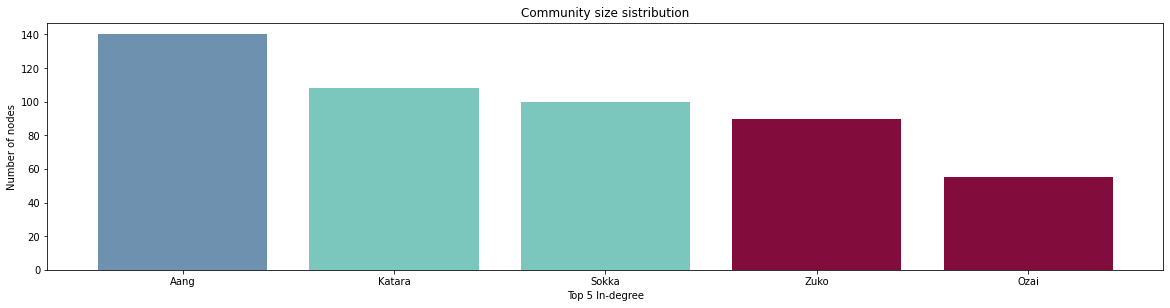

In [14]:
Image(filename='com_top_5_in.png') 

In the plot above we can see the top 5 in degree based on the characters with highest in degree. As we can see, Aang has the highest as we saw before, followed by Katara, Sokka, Zuko and Ozai wgich all play big roles in the series. 

We did the same plotting for the out degree and the plot can be seen bellow

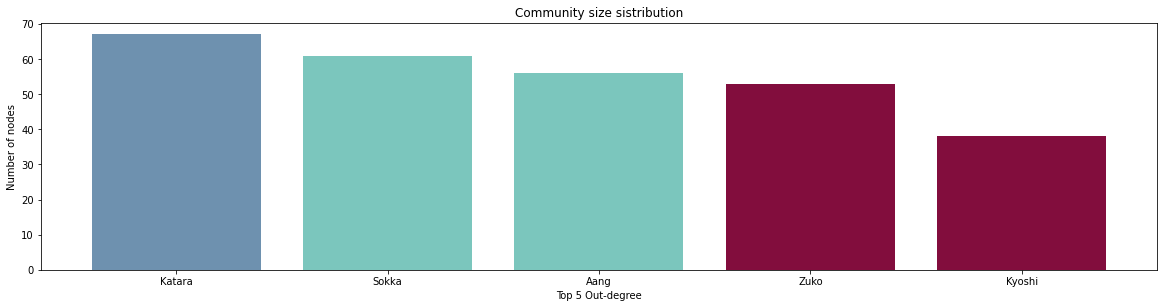

In [15]:
Image(filename='com_top_5_out.png') 

We were also interested in analyzing the in and out degree for each nation and just like before, we calculated each degree, created a dataframe and plotted the result. 

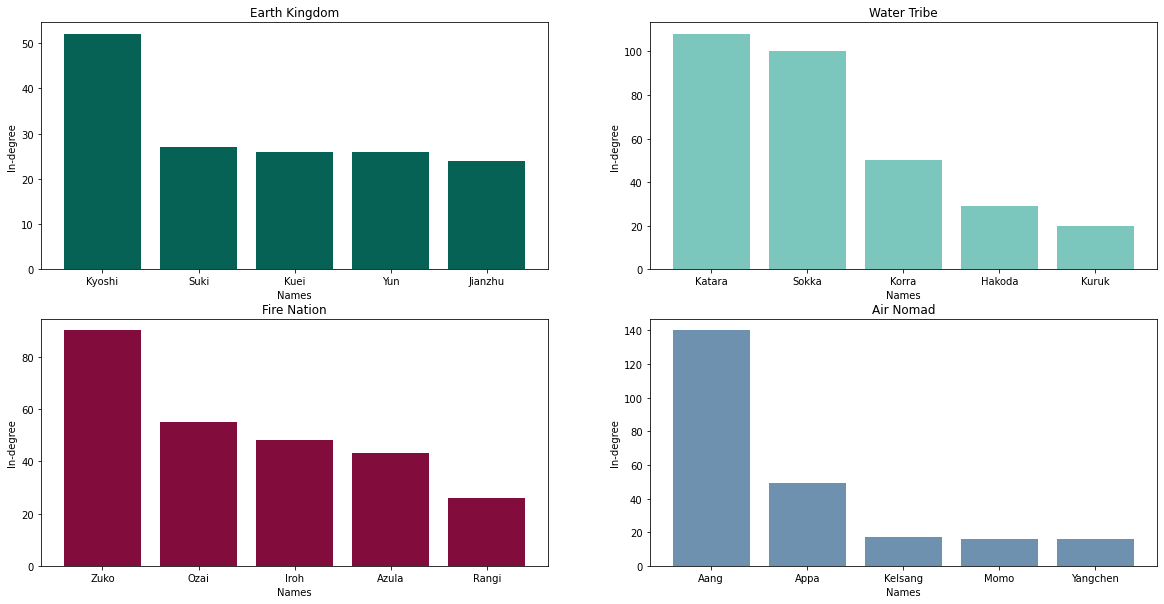

In [17]:
# In degree for the nations

Image(filename='nation_top_5_in.png') 

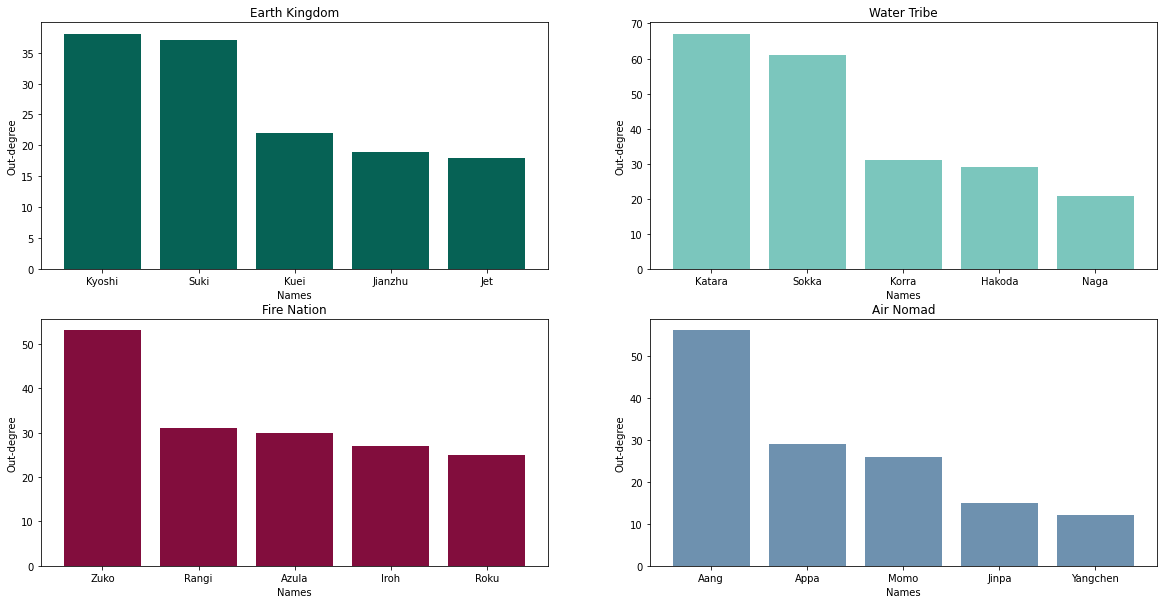

In [18]:
# Out degree for the nations 

Image(filename='nation_top_5_out.png') 

As we can see in the graphs above, the top 2 characters with both highest in and out degree are the same for each nation. This has made us believe that theese characters indeed are important when it comes to each nation but why? Who are they?

Kyoshi: "Only justice will bring peace." -  famouse words from the character from the earth kingdom. She can be vied as someone who was interested in justice and wanted peace throughout the nations.

Katara: Helps Aang in his journey and actually becomes his wife.

Zuko: Is the bad guys and he is the one that tries to get rid of Aang which makes him pretty important.

Aang: Aang is the main protagonist .

# Part 2 - The Network

In this part, we ctreate a beautiful graph that show the connection between characters and at the same time, what nation they are from. This was done, to understand who one should talk to if they wanted "important information" like how to obtain a bending method. To create a graph, we created another notebook for the script to not overload the explainer notebook with code. In short, the graph was created by adding the nodes, create the edges, decide the direction and the colors of the nations. The final result looks like this:


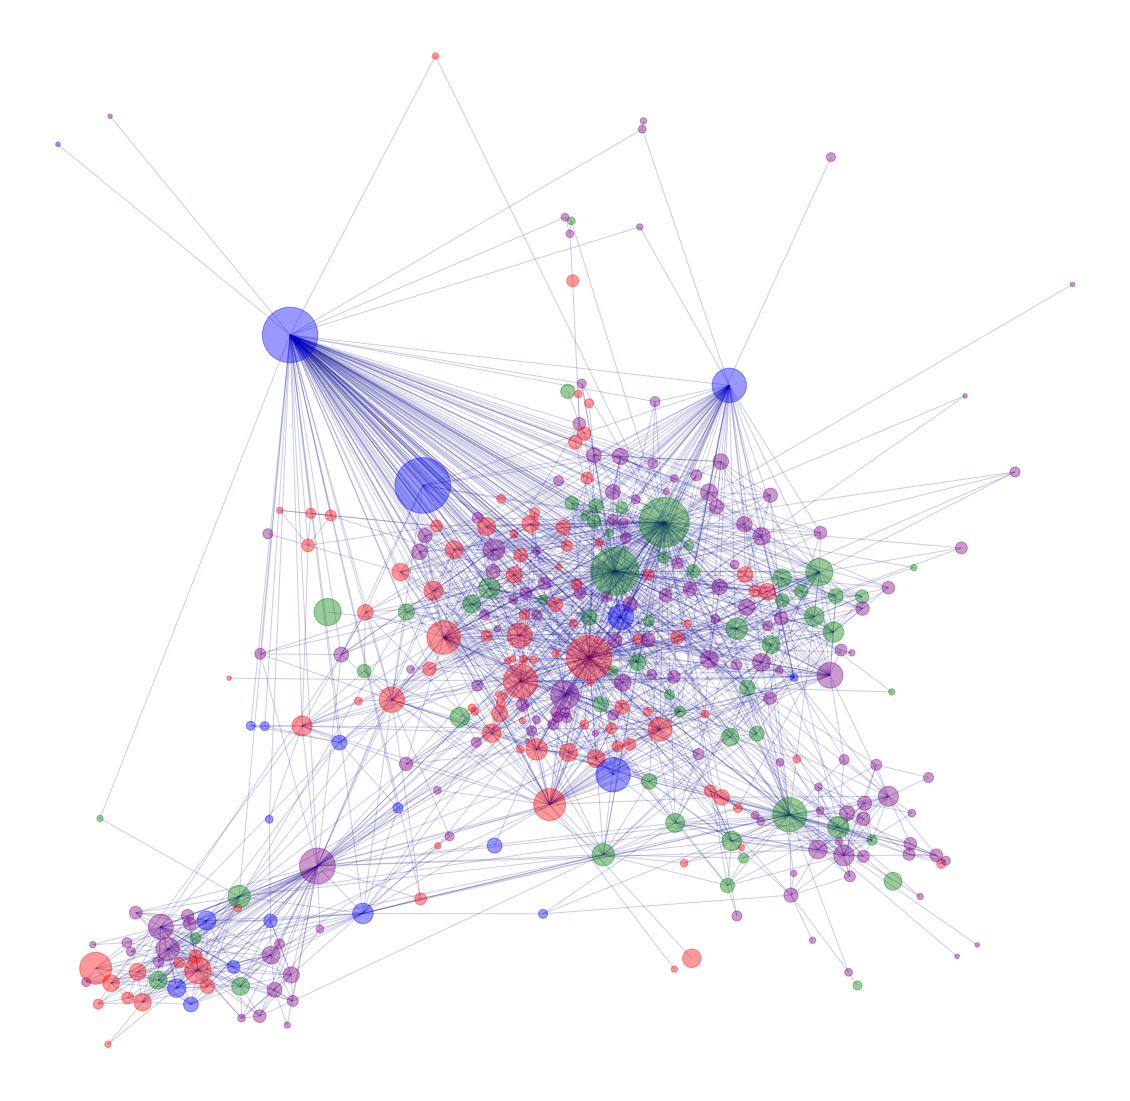

In [19]:
Image(filename='graph.png') 

The graph shows the connection between each character and the node size is based on how many relations a character has. The colors for each nations is

* Air Nomad - blue

* Earth Kingdom - purple

* Water Tribe - green

* Fire Nation - red

As we can see, there are most green (Earth Kingdom) and red nodes (Fire Nation). This makes sense if we look at the unique nation dataframe because we can see that they have most characters. We can also see that the blue nodes are the biggest even though they have fewest characters. The answer for this that Aang comes from the Air normads.

In [22]:
unique_nation

,Nation,Name
0,Air Nomad,23
1,Earth Kingdom,224
2,Fire Nation,154
3,Water Tribe,64


So what are the key takeaways from the graph? 

By analyzing it, we can conclude that it is most propable to find a character from the fire nation as they have most characters. So if you want to learn firebending, it should not be hard to find someone who can teach you. If you want to talk with someone from the Air Nomads on the other hand, it can be a challenge as the are quite rare in the world of Avatar. But if you manage to find someone from the Air Nomads, you better be starstruck, because they are pretty famous with all their connections.

# Part 3 - Sentiment analysis

Step 1: We explain what we're interested in.

Step 2: We explain the tool.

Step 3: We apply the tool.

Step 4: We discuss the outcome.


For the Sentiment analysis we were interested in finding out the most positive and negative characters. We also wanted to analyze the most common words in the world of Avatar. In order to do that we had to download all 61 episode transcripts from the fandom wikipage. We then use a function to extract every dialogue and put it in a dataframe with the character name. The Regex looked like this:

In [23]:
#-------------------------------- (?:\\n\!)(\w*\s*?\w*)(\\n\|.+?(?=\-\\n)) --------------------------------#

And what it did was to extract the character name followed by what the character said. This was all put into a dataframe which we then cleaned regarding the text. We tokenized the text, removed stopwords, lowercased and lemmatized.

In [26]:
# How the dataframe looked like before the text cleaning

pd.read_csv('transscript_df.csv')

,Unnamed: 0,Character,Text
0,0,Aang,"[""[''Frontal view.''] Wahoo! Hang on, Momo."", ..."
1,1,Actor Bumi,"[""Riddles and challenges you must face, [''Cam..."
2,2,Actor Iroh,"[""[Looking towards Actor Zuko, at ease] Prince..."
3,3,Actor Jet,"[""Don't cry, baby! Jet will wipe out that nast..."
4,4,Actor Ozai,"[""With the energy harnessed from that comet, n..."
...,...,...,...
268,268,Yung,"['Take them out.', 'Of course not! The day of ..."
269,269,Zei,"[""[''To the bartender.''] One mango, please."",..."
270,270,Zhang leader,['Where are the rest of the Gan Jin? Still tid...
271,271,Zhao,"[""[''Iroh and Zuko turn, with shocked expressi..."


In the sentiment analysis we wanted to identify the sentiment scores based on each nation to find out the happiest and saddest nation. In the script notebook the proces is detailed, but for now we only explain the proces in words. 

We used the SentimentIntensityAnalyzer from the vaderSentiment library to analyze the sentiment of each word said by a character. We then grouped the characters based on the nations and found that:

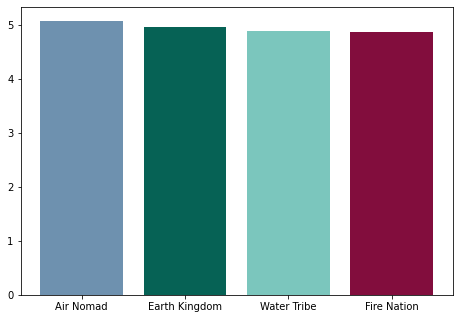

In [27]:
Image(filename='sentiment_nation.png') 

The Air Nomads is the most positive nation with the highest sentiment score. We can also see that the Fire Nation is the most negative nation. What is interesting, is that the Air nomads only consists of few characters and yet still are more positive than the Fire Nation witch has the most characters.

# Part 4 - WordClouds

The sentiment analysis sparked an interest in us, and we now wanted to find out what each nations says. We were interested in creating wordclouds based on each nations dialogue. This was done through the wordcloud library. For this part the major text cleaning was already done and we only needed to plot the wordclouds. 

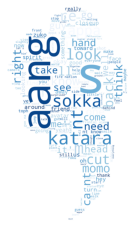

In [33]:
# wordcloud for the Air Nomads
Image(filename='aircloud.png') 

When looking at the wordcloud, we can clearly see that Aang is the most used word. This only makes sense as Aang is orginally from the Air Nomads and his name is widespread in that nation. Followed by his companion Katara they dominate the wordcloud.

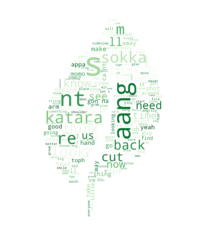

In [37]:
# wordcloud for the Earth Kingdom
Image(filename='earthcloud.png')

In the Earth Kingdom we see that Aang and Katara once again dominate the cloud. This makes sense, since they both travel from nation to nation in order to serve justice and master the 4 elements.

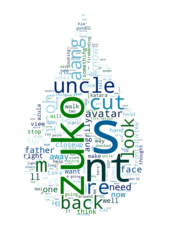

In [38]:
# wordcloud for the Water Tribe
Image(filename='watercloud.png')

The villain Zuko dominates the Water Tribe wordcloud as he is the main villain of the series and because he is from the fire nation, water people are the opposite of him. The contrast makes him an important perosn for the water tibe. 

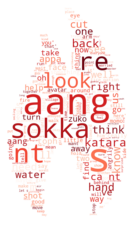

In [39]:
# wordcloud for the Fire Nation
Image(filename='firecloud.png')

As we also saw in the Water Tribe wordcloud, we again see connections between the water tribe and the fire nation. In the wordcloud we see words such as i.e water. We also see words that has to do with Zuko such as eye and cut (Zuko has a scar on his eye).

The wordclouds showed us that Aang and Katara are really famouse characters. In fact we see this throughout the whole project. In the in and out degrees, Aang and Katara has the highest degrees. In the network they both connect to most characters and even in the wordclouds, we can see that they once again dominate. 

### **4. Discussion. Think critically about your creation**

* What went well?

Because we have done the weekly exercises, every code in this project was something we have seen before (for the most part). This meant that we didnt encounter huge mistakes, where we couldnt find a solution in a previous weekly excercie. But because we were more free in this project and the descriptions didnt tell us what to do exactly, we were able to find and come up with codes that were much simpler than what we were used to i.e the loop function that got all queries and downloaded all wikipages within one codecell. 

* What is still missing? What could be improved?, Why?

Even though we are proud of our project, we still believe that there is space for improvement. This is a general thing which we learned the hard way. Having more structure in the notebook could have saved us a lot of times, maybe creating seperate notebooks for each part or section. Instead, we wrote the whole code in one notebook, which resultet in a lot of confusion because we got lost in all the dataframes and variable names. 

### **5. Contributions. Who did what?**

Even though we are not allowed to write "All members contributed equally", <-- dont worry we are not going to write that but the work in this project was done in such a way that not one group member took the lead role. 

But we devided the responsibility such that each group member was responsible for his/her part to work flawless. 

Hadil was responsible for the parts that had to do the creating and plotting networks and Mohammad was responsible for the wordclouds and regex parts. 

In the word sentiment both members were responsible.